<a href="https://colab.research.google.com/github/bnelson05/SelfAttention/blob/main/SelfAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model & Tokenizer Setup

#Choose a Public Sentiment Model

You can try distilbert-base-uncased-finetuned-sst-2-english or textattack/bert-base-uncased-SST-2—both are on Hugging Face.

Make sure it supports attention outputs. If it doesn’t by default, see if you can pass output_attentions=True in its config or when doing a forward pass.

# Load the Model & Tokenizer
Use AutoModelForSequenceClassification and AutoTokenizer, or you can directly reference the DistilBERT/BERT classes if that feels more comfortable.

Ensure the model is in eval mode (no training needed).

In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.config.output_attentions = True
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Pick 3–5 Sentences with Strong Sentiment
Examples:

“I absolutely love this film, but it’s also very disturbing.”

“The food was terrible, and I wouldn’t recommend it at all.”

Feel free to be creative. Maybe include negation (“not,” “never”) or contrasting words in a single sentence. For example, possibly include negations (“not,” “don’t”) or mixed signals (“I love the performance but hate the ending”).

In [6]:
sentiment_sentences = [
    "I loved this movie, but it was very sad.",
    "This film was incredible.",
    "This restaurant had good food, but the service was terrible.",
    "I was very disappointed by the movie ending."
]

#Retrieve Attention Weights

#Forward Pass
Tokenize each sentence and run model(**inputs).

The output should include a structure like outputs.attentions if you enable attention.

This is typically a tuple of size = number of layers, each shape [batch_size, num_heads, seq_len, seq_len].

In [9]:
for sentence in sentiment_sentences:
  inputs = tokenizer(sentence, return_tensors="pt")
  outputs = model(**inputs)
  print(f"Sentence: {sentence}")
  print(f"Num layers: {len(outputs.attentions)}, shape {outputs.attentions[0].shape}")

Sentence: I loved this movie, but it was very sad.
Num layers: 6, shape torch.Size([1, 12, 13, 13])
Sentence: This film was incredible.
Num layers: 6, shape torch.Size([1, 12, 7, 7])
Sentence: This restaurant had good food, but the service was terrible.
Num layers: 6, shape torch.Size([1, 12, 14, 14])
Sentence: I was very disappointed by the movie ending.
Num layers: 6, shape torch.Size([1, 12, 11, 11])


# Parse the Attention Tensor

If you’re processing one sentence at a time, you might have shape [num_heads, seq_len, seq_len] after removing the batch dimension.

You can decide whether to:

Visualize one specific head (e.g., head 0).

Average across all heads in a layer.

Compare layer 0 vs. the final layer vs some intermediate layer to see how attention changes deeper in the network.

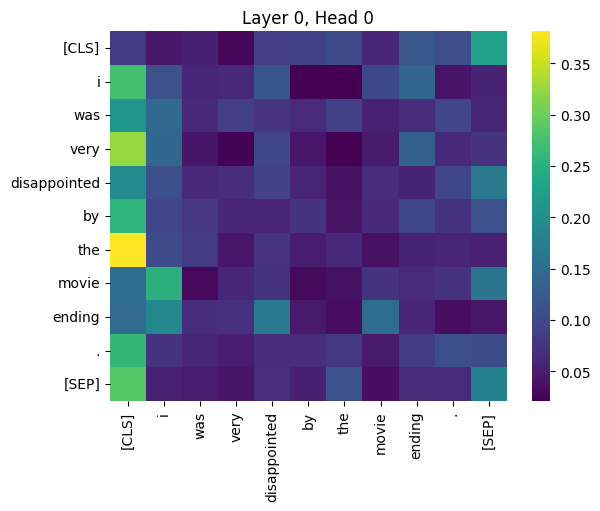

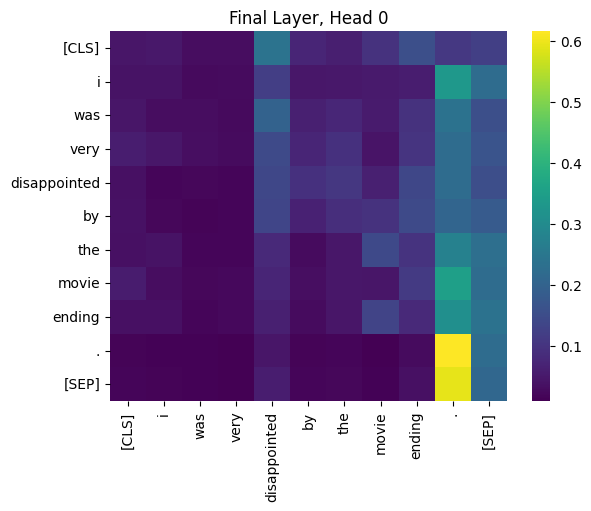

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

attention_zero_layer = outputs.attentions[0][0, 0].detach().numpy()

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

final_layer = len(outputs.attentions) - 1
attention_final_layer = outputs.attentions[final_layer][0, 0].detach().numpy()

sns.heatmap(attention_zero_layer, cmap='viridis', xticklabels=tokens, yticklabels=tokens)
plt.title("Layer 0, Head 0")
plt.show()

sns.heatmap(attention_final_layer, cmap='viridis', xticklabels=tokens, yticklabels=tokens)
plt.title("Final Layer, Head 0")
plt.show()

#Visualize & Analyze

# Heatmaps
Use a plotting library (e.g., matplotlib + seaborn) to create a heatmap.

Label the axes with your tokens so you can see which token is “attending” to which.

If the matrix is large, you can rotate axis labels or just focus on short sentences.

# Which Tokens Are Important?
Do sentiment words get strong attention from certain heads?

Does a token like “not” drastically change the attention pattern?

# Try a Few Variations
Compare single-head vs. multi-head average.

Possibly look at two different layers (e.g., first vs. last, 5th vs 4th).

If time allows, you can do multiple sentences that each highlight different aspects (negation, strongly negative, strongly positive, etc.).

Overall, the goal is to search for patterns among all layers of the network and among all heads of each of those layers. You can print all of these out in a loop and then see which ones exhibit some patterns.